In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Parent 1 Sleep: 3.94 hrs
Parent 2 Sleep: 3.94 hrs
Baby Sleep:    16.81 hrs
Total Cost:    13.12
Switching Penalty: 14.30


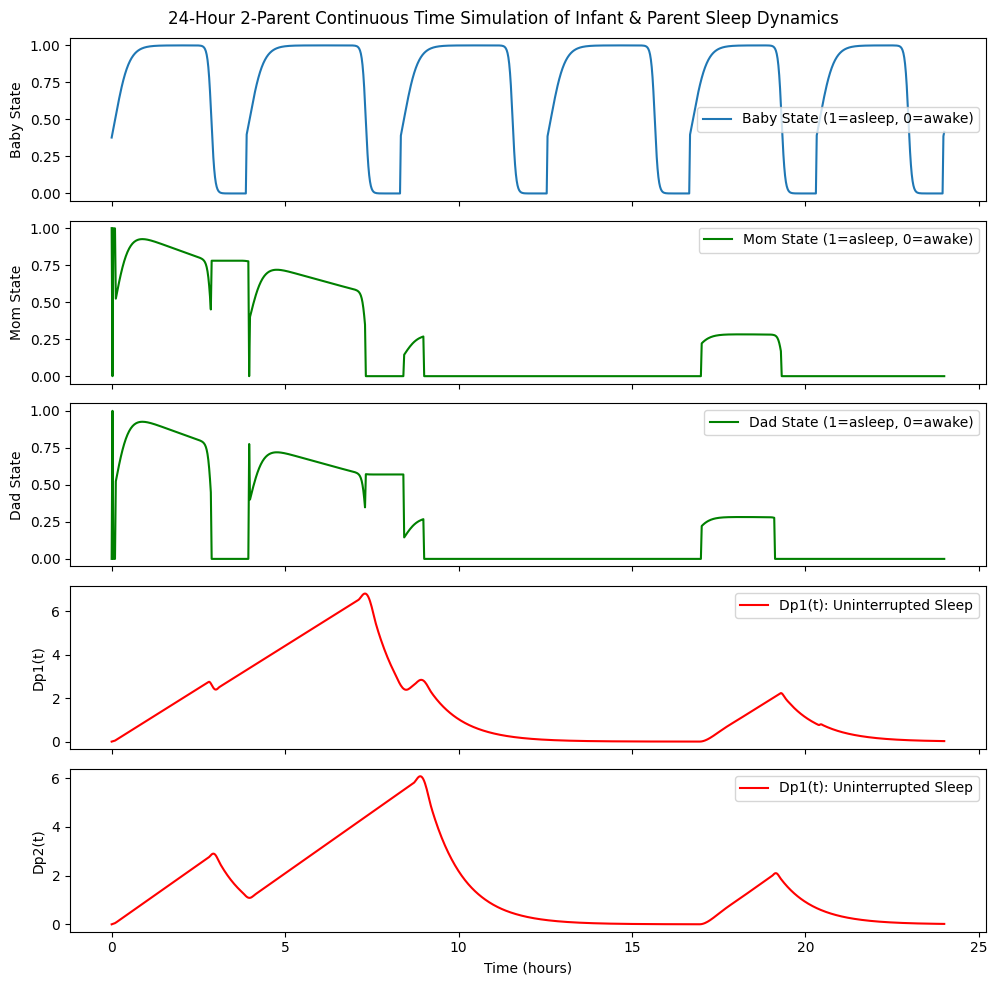

In [ ]:
np.random.seed(42)

# Constants
T = 24
K = 1.0
alpha = 0.5
lambda_reg = 1.0
sleep_cap = 10.0  # hard cap on raw sleep time

t_eval = np.linspace(0, T, 1000)
dt = t_eval[1] - t_eval[0]

# Precomputed baby sleep durations
n_cycles = int(np.ceil(T / 4)) + 1
sleep_durations = np.random.uniform(2.5, 3.5, size=n_cycles)

def B(t, sleep_durations, s_asleep=5, s_awake=20):
    t = np.atleast_1d(t)
    start_times = [0]
    for dur in sleep_durations[:-1]:
        start_times.append(start_times[-1] + dur + 1.0)
    start_times = np.array(start_times)
    cycle_index = np.searchsorted(start_times, t, side='right') - 1
    cycle_index = np.clip(cycle_index, 0, len(sleep_durations) - 1)
    local_t = t - start_times[cycle_index]
    sleep_dur = np.array([sleep_durations[i] for i in cycle_index])
    fall_asleep = 1 / (1 + np.exp(-s_asleep * (local_t - 0.1)))
    wake_up = 1 / (1 + np.exp(s_awake * (local_t - sleep_dur)))
    sleep_signal = fall_asleep * wake_up
    return sleep_signal if len(sleep_signal) > 1 else sleep_signal[0]

def delta(t):
    return np.where((t >= 0) & (t < 8), 0.9, 0.1)

def w(t):
    return 1.0 if 9 <= t < 17 else 0.0

def Z(t):
    return np.random.normal(0, 0.1)

# Control function with sleep cap logic
def u(t, x, sleep_durations):
    x1, x2, _, _, raw1, raw2 = x
    b = B(t, sleep_durations)
    sleep_need_1 = max(0, 1 - x1 / 9) if raw1 < sleep_cap else 0.0
    sleep_need_2 = max(0, 1 - x2 / 9) if raw2 < sleep_cap else 0.0
    night_factor = 1.0 if 0 <= t < 8 else 0.5

    if w(t) == 1:
        return [0.0, 0.0]
    if b < 0.5:
        return [0.0, sleep_need_2] if x1 > x2 else [sleep_need_1, 0.0]

    return [sleep_need_1 * b * night_factor,
            sleep_need_2 * b * night_factor]

# ODE system with raw sleep tracking
def sleep_ode(t, x, sleep_durations):
    x1, x2, dp1, dp2, raw1, raw2 = x
    u1, u2 = u(t, x, sleep_durations)
    b = B(t, sleep_durations)

    dx1 = delta(t) * u1 * b
    dx2 = delta(t) * u2 * b
    ddp1 = 1.0 if u1 > 0.01 else -dp1
    ddp2 = 1.0 if u2 > 0.01 else -dp2
    draw1 = 1.0 if u1 > 0.01 and raw1 < sleep_cap else 0.0
    draw2 = 1.0 if u2 > 0.01 and raw2 < sleep_cap else 0.0

    return [dx1, dx2, ddp1, ddp2, draw1, draw2]

# Solve
sol = solve_ivp(sleep_ode, [0, T], [0, 0, 0, 0, 0, 0], args=(sleep_durations,), t_eval=t_eval)
x1_vals, x2_vals, dp1_vals, dp2_vals, raw1_vals, raw2_vals = sol.y
t_vals = sol.t

# Recompute control and costs
u_vals = np.array([u(t, x, sleep_durations) for t, x in zip(t_vals, sol.y.T)])
u1_vals = u_vals[:, 0]
u2_vals = u_vals[:, 1]
b_vals = B(t_vals, sleep_durations)
w_vals = np.array([w(t) for t in t_vals])
z_vals = np.array([Z(t) for t in t_vals])
d_vals = delta(t_vals)

# Cost
integrand = (b_vals * (u1_vals**2 + u2_vals**2) / (K + 0.01)) - w_vals + alpha * z_vals
cost = np.trapz(integrand, t_vals)
du1_dt = np.diff(u1_vals) / dt
du2_dt = np.diff(u2_vals) / dt
switching_penalty = np.sum(np.abs(du1_dt) + np.abs(du2_dt)) * dt
cost += lambda_reg * switching_penalty

# Summary
print(f"Parent 1 Sleep: {x1_vals[-1]:.2f} hrs")
print(f"Parent 2 Sleep: {x2_vals[-1]:.2f} hrs")
print(f"Baby Sleep:    {np.trapz(b_vals, t_vals):.2f} hrs")
print(f"Total Cost:    {cost:.2f}")
print(f"Switching Penalty: {lambda_reg * switching_penalty:.2f}")

# Plot
fig, ax = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
fig.suptitle('24-Hour 2-Parent Continuous Time Simulation of Infant & Parent Sleep Dynamics')

ax[0].plot(t_vals, b_vals, label='Baby State (1=asleep, 0=awake)')
ax[0].set_ylabel('Baby State')
ax[0].legend()

ax[1].plot(t_vals, u1_vals, color='g', label='Mom State (1=asleep, 0=awake)')
ax[1].set_ylabel('Mom State')
ax[1].legend()

ax[2].plot(t_vals, u2_vals, color='g', label='Dad State (1=asleep, 0=awake)')
ax[2].set_ylabel('Dad State')
ax[2].legend()

ax[3].plot(t_vals, dp1_vals, color='r', label='Dp1(t): Uninterrupted Sleep')
ax[3].set_ylabel('Dp1(t)')
ax[3].legend()

ax[4].plot(t_vals, dp2_vals, color='r', label='Dp1(t): Uninterrupted Sleep')
ax[4].set_ylabel('Dp2(t)')
ax[4].set_xlabel('Time (hours)')
ax[4].legend()

plt.tight_layout()
plt.show()

